<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>ComCam Analsysis Sprint—False Positive Rates in DiaSources</b> <br>
Contact author: Erin Howard<br>
Last verified to run: April 24th, 2024<br>
LSST Science Piplines version: w_2024_16<br>
Container Size: Medium<br>

## Analysis Summary

* Horizontal structures in the noise are observations of the same field.
* There is no band specific structure in the noise (plot in related ticket).
* Majority of median SNR is ~5.5, there are differences between fields, and none are below 5.
* Code utilized from [this notebook](https://github.com/yalsayyad/dm_notebooks/blob/master/examples/DiaSourceCensusCcdVisitNight-HSC-RC2.ipynb) which takes from [DMTN-006](https://dmtn-006.lsst.io/#noise-in-difference-images), though since all of our SNR is above 5, we likely need to adjust the expectations to match more closely to our data.
* Per John Parejko: "the next question is whether that is telling us something about the nature of those fields themselves (stellar density?), or about the nature of the templates that were built in those fields."

## Table of Contents

1. [Imports, Helper Functions, and Loading](#section_1)
2. [Expected Noise](#section_2)

## 1. <a id="section_1">Imports, Helper Functions, and Loading</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lsst.daf.butler as dafButler
import functools
import operator

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

plt.set_loglevel('WARNING')

### Helper Functions and Variables

In [2]:
badFlagList=['pixelFlags_edge', 'pixelFlags_bad', 'pixelFlags_suspect',
             'pixelFlags_interpolatedCenter', 'pixelFlags_saturatedCenter', 'isDipole']

In [3]:
## Grouping tracts based on location
group1 = [3384, 3385]
group2 = [2261, 2262, 2494, 2495]
group3 = [9880, 9881, 9638]
group4 = [3533, 3534, 3345, 3346]
group5 = [7683, 7684, 7445, 7446]
group6 = [9590, 9591, 9347, 9348]
group7 = [9812, 9813]
group8 = [7149, 6914, 6915]

groups = [group1, group2, group3, group4, group5, group6, group7, group8]

In [4]:
def getUniqueVisits(collections, tracts):
    """Get the unique visits from a given tract."""
    visitList = []
    tracts = ','.join(str(tract) for tract in tracts)
    for d in sorted(registry.queryDatasets(datasetType="goodSeeingDiff_diaSrcTable", collections=collections, where=f"skymap='DC2' AND tract IN ({tracts})")): 
        visitList.append(d.dataId['visit'])
    uniqueVisits = list(set(visitList))
    return uniqueVisits

In [5]:
def getPsfSigma(butler, visit, psfDetector=0, badFlagList=None):
    """Count the number of diaSources for a given visit across all detectors, and
    retrieve a representative PSF size (sigma, i.e., seeing proxy) for the visit.

    Parameters
    ----------
    butler : `dafButler.butler` for getting stuff
    visit : `int`
    psfDetector : `int`, optional, used for retrieving psfSigma size only
    badFlagList : `list`, optional

    Returns
    -------
    psfSigma : `float`, the radius of the PSF sigma, from summaryStats
    nGoodDiaSources : `int`, the count of diaSources without badFlags
    band : `str`, the band the visit was taken in
    
    """
    psfSigma = butler.get("calexp.summaryStats", visit=visit, detector=psfDetector).psfSigma
    oneDiaSourceTable = butler.get("diaSourceTable", visit=visit)  # all detectors
    nDiaSources = len(oneDiaSourceTable)
    if badFlagList:
        badFlags = [oneDiaSourceTable[flag] for flag in badFlagList]
        flagFilter = functools.reduce(operator.or_, badFlags)
        noFlagFilter = ~flagFilter
        nGoodDiaSources = len(oneDiaSourceTable.loc[noFlagFilter])
        medianSNR = oneDiaSourceTable.loc[noFlagFilter].snr.median() # I changed this line
    else:
        nGoodDiaSources = nDiaSources

    return psfSigma, nGoodDiaSources, medianSNR

In [6]:
def n(v):
    """For an image with a Gaussian PSF of width sigma in pixels,
    return the density of detections per square degree above a threshold v.
    """
    return v*np.exp(-0.5*v*v)/(2**(5/2) * np.pi**(3/2))

def expectedPerVisit(low, high, seeing, bbox, nDetectors):
    """Compute number of detections expected for one visit.
    Note this calculation uses a PSF size sigma, not FWHM, per DMTN-006.

    Example: for DECam images with seeing (PSF sigma) = 1.8 pixels and a 2k by 4k pixel sensor,
    we expect 1.5 noise detections per sensor at 5 sigma, or 33 detections per square
    degree (twice that if counting both positive and negative detections).

    Parameters
    ----------
    low : `int` or `float`, low detection threshold value (e.g., 5 for 5 sigma)
    high : `int` or `float`, high detection threshold value
    seeing : `float` or `list` of `float`, PSF sigma values to use as a proxy for seeing
    bbox : `BBox` for a representative detector
    nDetectors : `int`, number of detectors in a visit (e.g., 9 for ComCam)

    Returns
    -------
    expectedValue : `float` or `list` of `float`
        Expected number of diaSources per visit, one per seeing value
    """
    inBetween = n(low) - n(high)
    
    # Multiply by 2 for positive and negative detections
    # Multiply by the number of detectors and the area of each detector

    #print(f"The seeing you inputted is {seeing}")
    
    nCols = bbox.getWidth()
    nRows = bbox.getHeight()
    #print(f"Each detector is {nRows} x {nCols} pixels, and there are {nDetectors} detectors")
    expectedValue = inBetween * 2 * nRows * nCols * nDetectors / (seeing**2)

    #print(f"The expected value per visit is {expectedValue}")
    
    return expectedValue

### Loading Data

In [7]:
repo = '/repo/ops-rehearsal-3-prep'
collections = 'u/homer/htc-test1'
instrument = 'LSSTComCamSim'
skymap = 'DC2'

butler = dafButler.Butler(repo, collections=collections, instrument=instrument, skymap=skymap)
registry = butler.registry

## 2. <a id="section_2">Expected Noise</a>

In [8]:
visitListByGroup = []

for group in groups:
    visits = getUniqueVisits(collections, group)
    visitListByGroup.append(visits)
    print("There are "+str(len(visits))+f"visits in tracts {group}")

There are 60visits in tracts [3384, 3385]
There are 302visits in tracts [2261, 2262, 2494, 2495]
There are 360visits in tracts [9880, 9881, 9638]
There are 660visits in tracts [3533, 3534, 3345, 3346]
There are 420visits in tracts [7683, 7684, 7445, 7446]
There are 360visits in tracts [9590, 9591, 9347, 9348]
There are 360visits in tracts [9812, 9813]
There are 360visits in tracts [7149, 6914, 6915]


In [9]:
bbox = butler.get('calexp.bbox', visit=visitListByGroup[0][0], detector=0)
PIXEL_SCALE = butler.get('calexp.wcs', visit=visitListByGroup[0][0], detector=0).getPixelScale().asDegrees()
APPROX_CCD_AREA =  PIXEL_SCALE*PIXEL_SCALE*bbox.getArea()
N_CCD = 9
APPROX_VISIT_AREA = APPROX_CCD_AREA * N_CCD
print(f"ComCam visit area is {APPROX_VISIT_AREA} square degrees")

ComCam visit area is 0.4529235509696138 square degrees


In [10]:
allMedianSNR = []
medianSNRbyGroup = []
def diaSourceCountExpectedPlot(butler, visitListByGroup, visitArea, nDetectors, badFlagList):
    """Plot how many diaSources we are measuring per square degree
    alongside a line showing how many we would naively expect
    due to Gaussian noise alone with a 5 sigma detection threshold.
    """
    
    psfSigmaListTotal = []
    
    plt.figure(figsize=(8,4))
    ax = plt.subplot(111)
    plt.yscale('log')
    plt.ylabel('N diaSources (per sq deg)')
    plt.xlabel('psfSigma (pixels)')

    for groupNum, visitList in enumerate(visitListByGroup):
        psfSigmaList = []
        nGoodDiaSources = []
        medianSNR = []
    
        for visit in visitList:
            goodPsfStats = getPsfSigma(butler, visit, psfDetector=0, badFlagList=badFlagList)  # this returns (psfSigma, nGoodDiaSources) for each visit
            psfSigmaList.append(goodPsfStats[0])
            nGoodDiaSources.append(goodPsfStats[1])
            medianSNR.append(goodPsfStats[2])
            allMedianSNR.append(goodPsfStats[2])

        medianSNRbyGroup.append(medianSNR)
        nGoodDiaSourcesPerArea = [n/visitArea for n in nGoodDiaSources]
        psfSigmaListTotal = psfSigmaListTotal + list(psfSigmaList)
        
        plt.scatter(psfSigmaList, nGoodDiaSourcesPerArea, marker='.', alpha=0.5, label=f"Tracts {groups[groupNum]}")

    psfSigmaRange = np.linspace(np.min(psfSigmaListTotal), np.max(psfSigmaListTotal), 20)
    bbox = butler.get('calexp.bbox', visit=visitList[0], detector=0)
    expectedPerArea = expectedPerVisit(5, 100, psfSigmaRange, bbox, nDetectors) / visitArea
        
    plt.plot(psfSigmaRange, expectedPerArea, label="Expected diaSource count, SNR > 5", c='C2')
    # maybe add a title
    plt.legend()
    plt.tight_layout()

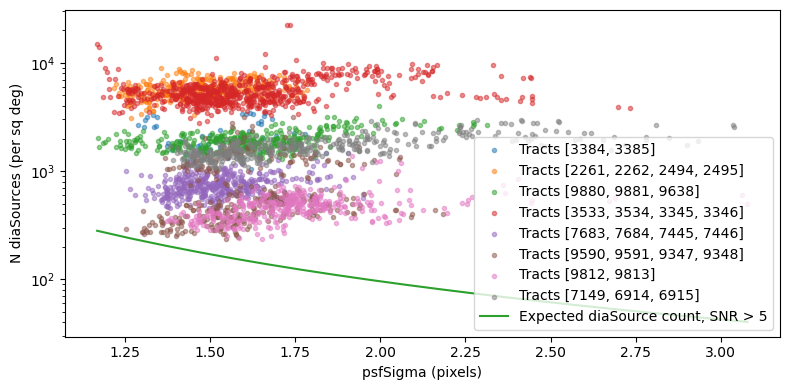

In [11]:
diaSourceCountExpectedPlot(butler, visitListByGroup, APPROX_VISIT_AREA, N_CCD, badFlagList)

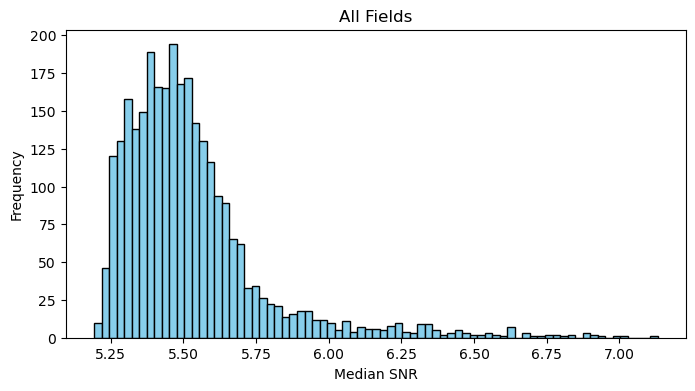

In [12]:
plt.figure(figsize=(8,4))

# Plotting a basic histogram
plt.hist(allMedianSNR, bins=75, color='skyblue', edgecolor='black')
 
# Adding labels and title
plt.xlabel('Median SNR')
plt.ylabel('Frequency')
plt.title('All Fields')
 
# Display the plot
plt.show()

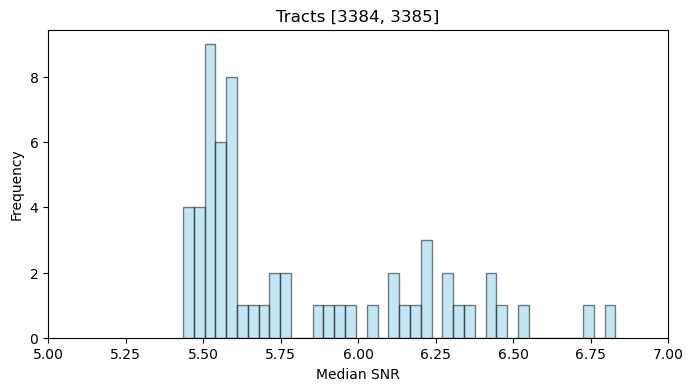

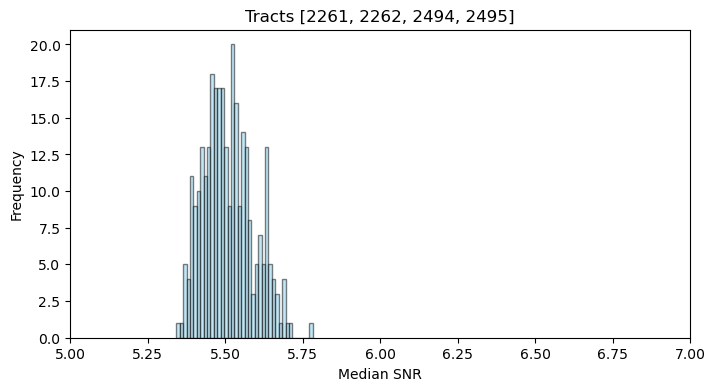

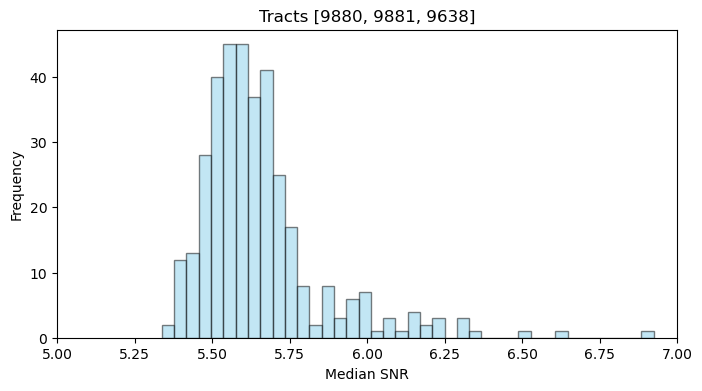

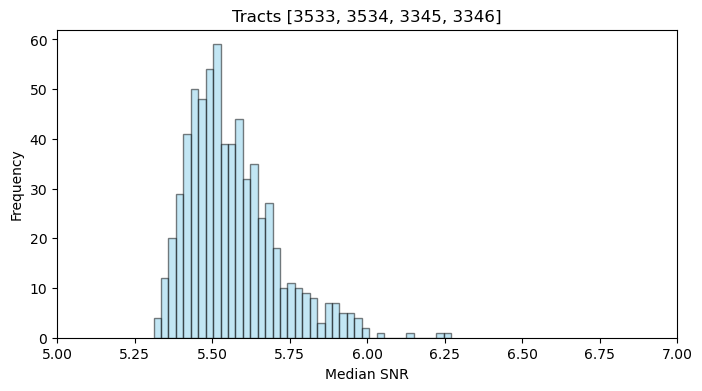

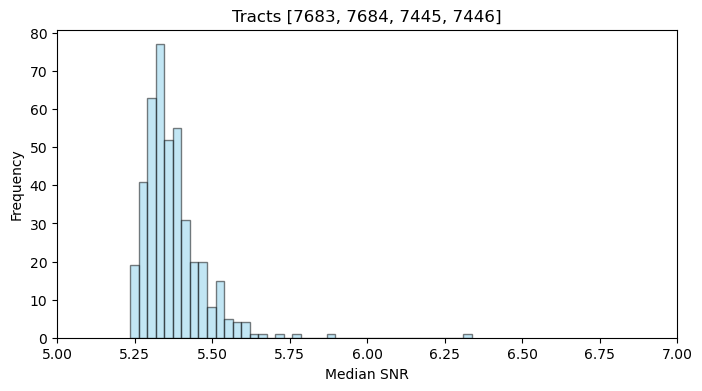

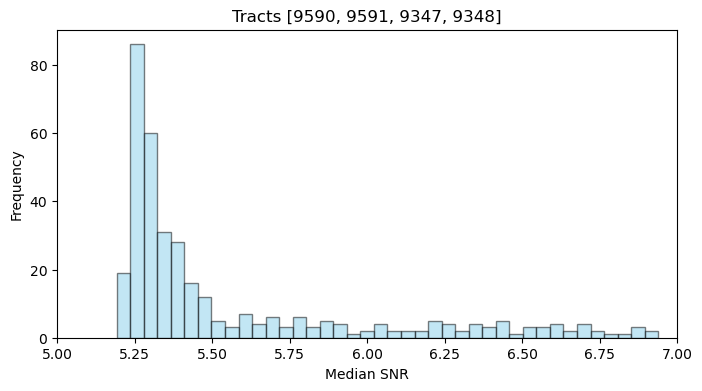

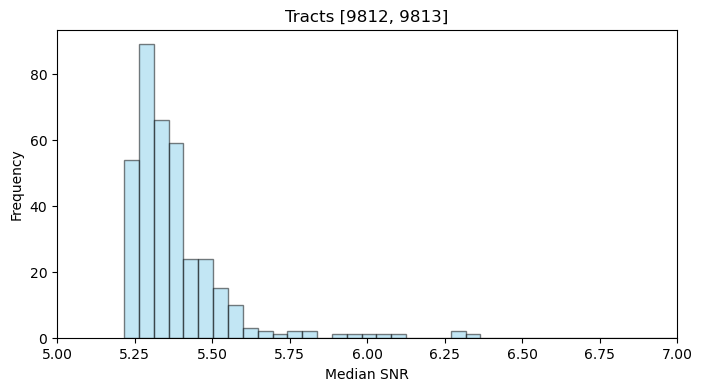

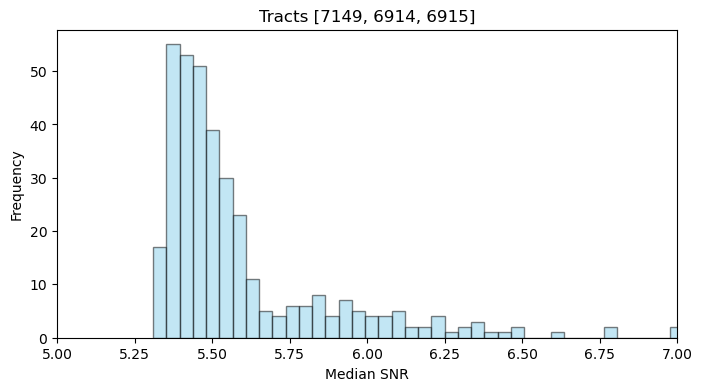

In [13]:
for i, group in enumerate(groups):
    plt.figure(figsize=(8,4))

    # Plotting a basic histogram
    plt.hist(medianSNRbyGroup[i], bins=40, color='skyblue', edgecolor='black', alpha=0.5)
     
    # Adding labels and title
    plt.xlabel('Median SNR')
    plt.ylabel('Frequency')
    plt.xlim(5,7)
    plt.title(f'Tracts {groups[i]}')
     
    # Display the plot
    plt.show()